In [1]:
# import modules

import numpy as np
import pandas as pd

# for prepocessing

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# for splitting to training and test set
from sklearn.model_selection import train_test_split

# for scaling
from sklearn.preprocessing import StandardScaler

# for cross-validaton
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

# for model evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# for PCA and umap

from sklearn.decomposition import PCA
import umap

# plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly.express as px

# extra
import warnings
warnings.filterwarnings('ignore')


# 1. Introduction

The aim of this notebook is to train a couple of machine learning models (logistic regression, knn classifier, random forest classifier, gradient boosting classifier and multilayer perceptron) using scikit-learn to predict diabetes status (binary classification problem) based on a number of available variables. We train the models using accuracy but we compare the models according to multiple performance measures using 5-fold cross-validation. Data preprocessing, hyperparameter tuning and model comparison are part of this exercise. 

The data are originally from [Kaggle](https://www.kaggle.com/datasets/mathchi/diabetes-data-set) but I downloaded it as a csv file on my own computer.

Sources:

DataCamp course on supervised machine learning with scikit-learn ([here](https://app.datacamp.com/learn/courses/supervised-learning-with-scikit-learn))

[https://python-forum.io/thread-38127.html]

[https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html]

[https://www.statology.org/plot-multiple-roc-curves-python/]

[https://towardsdatascience.com/scattered-boxplots-graphing-experimental-results-with-matplotlib-seaborn-and-pandas-81f9fa8a1801]

[https://www.geeksforgeeks.org/classification-using-sklearn-multi-layer-perceptron/]

# 2. Import and explore data

## Data import

In [2]:
# import data

df = pd.read_csv('diabetes.csv')  
df.head(5)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Data exploration

First, we explore the shape of the dataset. There are 768 rows (observations) and 9 variables. We also explore the properties of the dataframe and the variables such as data types and descriptive statistics. The last column is the target variable containing the diabetes status. About 34% of the sample has diabetes.

If we explore the information obtained with the functions below we would get the impression that the dataset is complete, there are not any missing data. Investigating the histograms, however, we find that there are a couple of variables that contain zeros even if it does not make sense (skin thickness, insulin, blood pressure, glucose, BMI). We replace the zeros with NaN in these columns.

In [3]:
# shape of dataset

df.shape

(768, 9)

In [4]:
# types of variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
# distribution of values, are there outliers and or potentially missing values?
# descriptive statistics per variable

df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

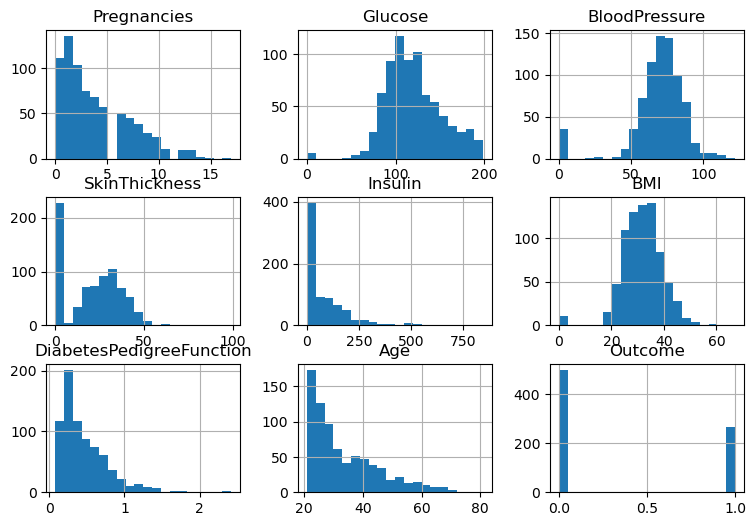

In [6]:
df.hist(bins=20, figsize=(9, 6))

Conclusion and notes:

1. This is a classification exercise, we would like to predict diabetes status (0-no diabetes, 1-diabetes).
2. We have an imbalanced classification problem: we have more 0's than 1's (~34.9% of the sample has diabetes). There are several strategies as to how to handle this potential problem ([here](https://datasciencehorizons.com/handling-imbalanced-datasets-in-scikit-learn-techniques-and-best-practices/) and [here](https://imbalanced-learn.org/stable/user_guide.html#user-guide)). We do not do it in this analysis. First, we develop and finetune our model.
3. The dataset looks like as one without missing values. However, when you look at the values we find a couple of variables with zeros where there should not be any zeros (glucose, blood pressure, skin thickness, insulin and BMI). We recode zeros in these variables as missing. This strategy creates a lot of missing for skin thickness and insulin, so we do not use these variables as predictors. (An alternative strategy is to exclude only insulin as predictor, because we still have enough sample after removing missing values recoded from 0 for skin thickness.)

In [7]:
# replacing zeros with NA

df = df.replace({'Glucose': {0: np.nan}, 'BloodPressure': {0: np.nan}, 'BMI': {0: np.nan},
                'Insulin': {0: np.nan}, 'SkinThickness': {0: np.nan}})


In [8]:
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [9]:
# inspect result missing values

df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

# 3. Data preprocessing - cleaning and creating numpy arrays

Skin thickness and insulin have the most NaN now. When we have this many missing values, we do not impute them. Instead, we drop the two columns. Some other variables also have missing values. Instead of imputing (which is a valid option), we just remove observations which have at least one missing value. In other words, we keep the complete cases only. The remaining number of observations is 724 and the remaining number of columns is 7. The share of observations with diabetes did not change much with the removal of some cases. The final step in this section is to separate features and the target variable and transform them into numpy arrays.

In [10]:
# we drop the columns with a lot of missing

df = df.drop(['SkinThickness', 'Insulin'], axis='columns')
print(df.shape)

(768, 7)


In [11]:
# keep only complete cases
df = df.dropna()
print(df.shape)

(724, 7)


In [12]:
# inspect the data again
df.describe()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
count,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000,724.000000
mean,3.866022,121.882597,72.400552,32.467127,0.474765,33.350829,0.343923
std,3.362803,30.750030,12.379870,6.888941,0.332315,11.765393,0.475344
min,0.000000,44.000000,24.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,27.500000,0.245000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,32.400000,0.379000,29.000000,0.000000
75%,6.000000,142.000000,80.000000,36.600000,0.627500,41.000000,1.000000
max,17.000000,199.000000,122.000000,67.100000,2.420000,81.000000,1.000000


array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'BMI'}>,
        <Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'Outcome'}>, <Axes: >, <Axes: >]],
      dtype=object)

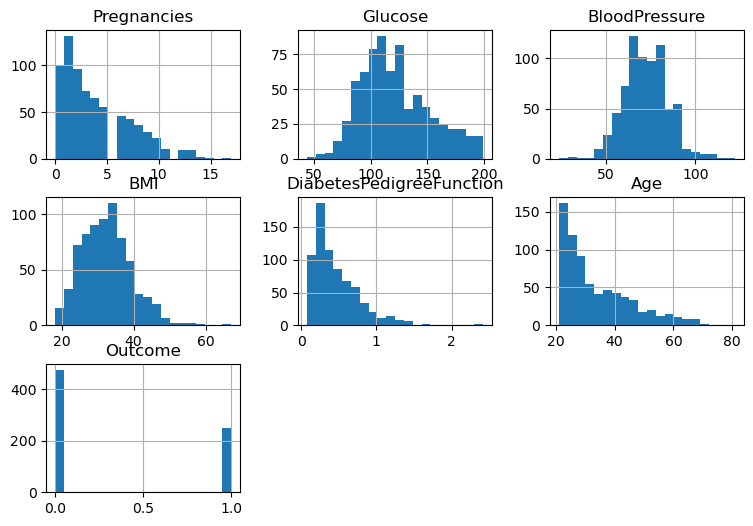

In [13]:
df.hist(bins=20, figsize=(9, 6))

In [14]:
df.head(5)

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,33.6,0.627,50,1
1,1,85.0,66.0,26.6,0.351,31,0
2,8,183.0,64.0,23.3,0.672,32,1
3,1,89.0,66.0,28.1,0.167,21,0
4,0,137.0,40.0,43.1,2.288,33,1


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 724 entries, 0 to 767
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               724 non-null    int64  
 1   Glucose                   724 non-null    float64
 2   BloodPressure             724 non-null    float64
 3   BMI                       724 non-null    float64
 4   DiabetesPedigreeFunction  724 non-null    float64
 5   Age                       724 non-null    int64  
 6   Outcome                   724 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 45.2 KB


In [16]:
# creating numpy arrays

# features
X = df.drop(['Outcome'], axis='columns').values

# target
y = df['Outcome'].values

print(X.shape, y.shape)

# inspect the first 6 observations
print(X[0:6,])
print(y[0:6,])


(724, 6) (724,)
[[6.000e+00 1.480e+02 7.200e+01 3.360e+01 6.270e-01 5.000e+01]
 [1.000e+00 8.500e+01 6.600e+01 2.660e+01 3.510e-01 3.100e+01]
 [8.000e+00 1.830e+02 6.400e+01 2.330e+01 6.720e-01 3.200e+01]
 [1.000e+00 8.900e+01 6.600e+01 2.810e+01 1.670e-01 2.100e+01]
 [0.000e+00 1.370e+02 4.000e+01 4.310e+01 2.288e+00 3.300e+01]
 [5.000e+00 1.160e+02 7.400e+01 2.560e+01 2.010e-01 3.000e+01]]
[1 0 1 0 1 0]


# 4. Comparing models with default settings on the whole dataset

To get a sense of the models, we investigate how they perform with their default settings (see scikit-learn documentation) on the whole dataset without scaling. We use 5-fold cross-validation (CV). The first four models perform very similarly. The MLP performs apparently a bit worse than the others.

In [17]:
# Prepare the models
# models
models = []
models.append(('Logistic', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('Gradient boosting', GradientBoostingClassifier()))
models.append(('Multilayer Perceptron', MLPClassifier()))

# Evaluate models based on accuracy with cross-validation
results = []
names = []
seed = 13
scoring = 'accuracy'
for name, model in models:
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X, y, cv=kf, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = ('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    print(msg)


Logistic: 0.763831 (0.037757)
KNN: 0.755575 (0.037392)
Random Forest: 0.758324 (0.034110)
Gradient boosting: 0.772146 (0.040927)
Multilayer Perceptron: 0.708582 (0.028207)


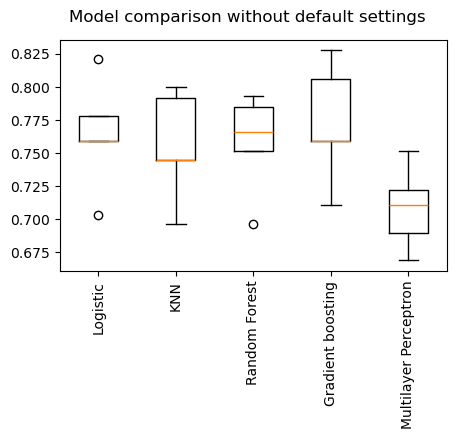

In [18]:
# plotting

# Boxplot Algorithm Comparison
fig = plt.figure(figsize=(5,3))
fig.suptitle('Model comparison without default settings')
ax = fig.add_subplot(111)
plt.boxplot(results, labels=names)
plt.xticks(rotation=90)
plt.show()

# 5. Data preprocessing - splitting and scaling

Before training the models and fine-tuning the hyperparameters, we split the dataset into training  and test data (test size=0.2). We train the models on the training data with cross-validation and evaluate the models on the test data. The test set has 145 observations and the training set has 579 observations. Then, we scale the data to have variables with zero mean and unit standard deviation. There are other transformation methods that could be useful. Important: we scale only the features and the test and train data separately.

## Splitting

In [19]:
# splitting

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

In [20]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(579, 6) (579,) (145, 6) (145,)


## Scaling

In [21]:
# applying standard scaler

scaler=StandardScaler()

# training data
X_train_scaled = scaler.fit_transform(X_train)

# test data
X_test_scaled = scaler.transform(X_test)

# 6. Hyperparameter tuning and model optimization

In this section we train the five models, tune some hyperparameters and fit the models with the best parameters on the test set and we save out the predicted classes, predicted probabilities, performance scores, false positive rate and true positive rate for the ROC curves and the ROC AUC's. The evaluation happens in the next section where we present some inbuilt visualisation but we build some custom tools as well. 

## Model 1: Logistic Regression

In [22]:
# help: https://medium.com/@rithpansanga/logistic-regression-and-regularization-avoiding-overfitting-and-improving-generalization-e9afdcddd09d
# initiating 5-fold cross validation
kf=KFold(n_splits=5, shuffle=True, random_state=13)

# grid search cross validation
param_grid={"C": np.linspace(0.00000,10, num=25),
           "penalty": [None, "l1", "l2" ]}

# initiating model
lr=LogisticRegression()

# initiating grid search
lr_cv=GridSearchCV(lr, param_grid, cv=kf)

# fitting the best model based on grid search on train set
lr_cv.fit(X_train_scaled, y_train)

# printing the parameters of the best model and the score on train set
print("\nParameters of best model:")
print(lr_cv.best_params_)
print("\nScore of best model:")
print(lr_cv.best_score_)


Parameters of best model:
{'C': 0.4166666666666667, 'penalty': None}

Score of best model:
0.7719940029985009


In [23]:
# fitting with the best paramaters on the test set

lr_best=LogisticRegression(penalty=None, C=0.4166666666666667)
lr_best.fit(X_test_scaled, y_test)
# predicting classes and probabilities
y_pred_best_lr = lr_best.predict(X_test_scaled)
y_pred_best_probs_lr=lr_best.predict_proba(X_test_scaled)[:, 1]
# confusion matrix
confusion_matrix_lr=confusion_matrix(y_test, y_pred_best_lr)

# performance scores
# accuracy
accuracy_lr=accuracy_score(y_test, y_pred_best_lr)
# precision
precision_lr=precision_score(y_test, y_pred_best_lr)
# recall
recall_lr=recall_score(y_test, y_pred_best_lr)
# F1
f1_lr=f1_score(y_test, y_pred_best_lr)

# ROC curve and ROC AUC

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_best_probs_lr)
auc_lr = round(roc_auc_score(y_test, y_pred_best_probs_lr), 4)

## Model 2: K Nearest Neighbors (KNN)

In [24]:
# grid search cross validation
param_grid={"n_neighbors": np.arange(1,25),
           "weights": ["uniform", "distance"],
           "algorithm": ["ball_tree", "kd_tree", "brute"],
           "leaf_size": [3, 5, 10, 15]}

# initiating model
knn=KNeighborsClassifier()

# initiating grid search
knn_cv=GridSearchCV(knn, param_grid, cv=kf)

# fitting the best model based on grid search on train set
knn_cv.fit(X_train_scaled, y_train)

# printing the parameters of the best model and the score on train set
print("\nParameters of best model:")
print(knn_cv.best_params_)
print("\nScore of best model:")
print(knn_cv.best_score_)


Parameters of best model:
{'algorithm': 'ball_tree', 'leaf_size': 3, 'n_neighbors': 21, 'weights': 'distance'}

Score of best model:
0.7685007496251874


In [25]:
# fitting with the best paramaters on the test set
knn_best=KNeighborsClassifier(n_neighbors=21,
                             leaf_size=3,
                             weights='distance',
                             algorithm='ball_tree')
knn_best.fit(X_test_scaled, y_test)
# predicting classes and probabilities
y_pred_best_knn = knn_best.predict(X_test_scaled)
y_pred_best_probs_knn=knn_best.predict_proba(X_test_scaled)[:, 1]
# confusion matrix
confusion_matrix_knn=confusion_matrix(y_test, y_pred_best_knn)

# perfromance scores
# accuracy
accuracy_knn=accuracy_score(y_test, y_pred_best_knn)
# precision
precision_knn=precision_score(y_test, y_pred_best_knn)
# recall
recall_knn=recall_score(y_test, y_pred_best_knn)
# F1
f1_knn=f1_score(y_test, y_pred_best_knn)

# ROC curve and ROC AUC

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_best_probs_knn)
auc_knn = round(roc_auc_score(y_test, y_pred_best_probs_knn), 4)

## Model 3: Random Forest 

In [26]:
# grid search cross validation
param_grid={"criterion": ["gini", "entropy", "log_loss"],
           "n_estimators": [10, 50, 100],
           "max_features": ["sqrt", "log2"],
           "max_depth": [4, 6, 8, 10, 15]}

# initiating model
rf=RandomForestClassifier(random_state=13)

# initiating grid search
rf_cv=GridSearchCV(rf, param_grid, cv=kf, return_train_score=True)

# fitting the best model based on grid search on train set
rf_cv.fit(X_train_scaled, y_train)

# printing the parameters of the best model and the score on train set
print("\nParameters of best model:")
print(rf_cv.best_params_)
print("\nScore of best model:")
print(rf_cv.best_score_)


Parameters of best model:
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}

Score of best model:
0.7910344827586206


In [27]:
# fitting with the best paramaters on the test set
rf_best=RandomForestClassifier(criterion='entropy',
                             max_depth=10,
                             max_features='sqrt',
                             n_estimators=100)
rf_best.fit(X_test_scaled, y_test)
# predicting classes and probabilities
y_pred_best_rf = rf_best.predict(X_test_scaled)
y_pred_best_probs_rf=rf_best.predict_proba(X_test_scaled)[:, 1]
# confusion matrix
confusion_matrix_rf=confusion_matrix(y_test, y_pred_best_rf)

# performance scores
# accuracy
accuracy_rf=accuracy_score(y_test, y_pred_best_rf)
# precision
precision_rf=precision_score(y_test, y_pred_best_rf)
# recall
recall_rf=recall_score(y_test, y_pred_best_rf)
# F1
f1_rf=f1_score(y_test, y_pred_best_rf)

# ROC curve and ROC AUC

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_best_probs_rf)
auc_rf = round(roc_auc_score(y_test, y_pred_best_probs_rf), 4)

## Model 4: Gradient Boosting

In [28]:
# grid search cross validation
param_grid={"loss": ["log_loss", "exponential"],
           "learning_rate": [0, 0.0005, 0.001, 0.1, 0.2, 0.5, 1, 10],
           "n_estimators": [50,100, 200],
            "criterion": ["friedman_mse", "squared_error"],
           "max_depth": [1,3,5]}

# initiating model
gb=GradientBoostingClassifier()

# initiating grid search
gb_cv=GridSearchCV(gb, param_grid, cv=kf)

# fitting the best model based on grid search on train set
gb_cv.fit(X_train_scaled, y_train)

# printing the parameters of the best model and the score on train set
print("\nParameters of best model:")
print(gb_cv.best_params_)
print("\nScore of best model:")
print(gb_cv.best_score_)


Parameters of best model:
{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 1, 'n_estimators': 50}

Score of best model:
0.7909745127436281


In [29]:
# fitting with the best paramaters on the test set
gb_best=GradientBoostingClassifier(loss='log_loss',
                             max_depth=1,
                             learning_rate=0.1,
                             n_estimators=50,
                                  criterion='friedman_mse')
gb_best.fit(X_test_scaled, y_test)
# predicting classes and probabilities
y_pred_best_gb = gb_best.predict(X_test_scaled)
y_pred_best_probs_gb=gb_best.predict_proba(X_test_scaled)[:, 1]
# confusion matrix
confusion_matrix_gb=confusion_matrix(y_test, y_pred_best_gb)

# performance scores
# accuracy
accuracy_gb=accuracy_score(y_test, y_pred_best_gb)
# precision
precision_gb=precision_score(y_test, y_pred_best_gb)
# recall
recall_gb=recall_score(y_test, y_pred_best_gb)
# F1
f1_gb=f1_score(y_test, y_pred_best_gb)

# ROC curve and ROC AUC

fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_best_probs_gb)
auc_gb = round(roc_auc_score(y_test, y_pred_best_probs_gb), 4)

## Model 5: Neural Network - Multilayer Perceptron

In [30]:
# grid search cross validation
param_grid={"hidden_layer_sizes": [(100,), (128, 64, 32), (64, 32), (32, 16)],
           "activation": ['relu', 'logistic' ,'tanh'],
           "solver": ['sgd', 'adam' ,'lbfgs'],
           "alpha": [0.0001, 0.001 ,0.1, 0.5]}

# initiating model
mlp=MLPClassifier()

# initiating grid search
mlp_cv=GridSearchCV(mlp, param_grid, cv=kf)

# fitting the best model based on grid search on train set
mlp_cv.fit(X_train_scaled, y_train)

# printing the parameters of the best model and the score on train set
print("\nParameters of best model:")
print(mlp_cv.best_params_)
print("\nScore of best model:")
print(mlp_cv.best_score_)


Parameters of best model:
{'activation': 'relu', 'alpha': 0.5, 'hidden_layer_sizes': (64, 32), 'solver': 'sgd'}

Score of best model:
0.7806296851574213


In [31]:
# fitting with the best paramaters on the test set
mlp_best=MLPClassifier(activation='relu', hidden_layer_sizes=(64, 32), solver='sgd', alpha=0.1)
mlp_best.fit(X_test_scaled, y_test)
# predicting classes and probabilities
y_pred_best_mlp = mlp_best.predict(X_test_scaled)
y_pred_best_probs_mlp=mlp_best.predict_proba(X_test_scaled)[:, 1]
# confusion matrix
confusion_matrix_svc=confusion_matrix(y_test, y_pred_best_mlp)

# accuracy
accuracy_mlp=accuracy_score(y_test, y_pred_best_mlp)
# precision
precision_mlp=precision_score(y_test, y_pred_best_mlp)
# recall
recall_mlp=recall_score(y_test, y_pred_best_mlp)
# F1
f1_mlp=f1_score(y_test, y_pred_best_mlp)

# ROC curve and ROC AUC

fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_pred_best_probs_mlp)
auc_mlp = round(roc_auc_score(y_test, y_pred_best_probs_mlp), 4)

# 7. Model evaluation

We explore the followinf evaluation tools: confusion matrices, performance measures and ROC curves with area under the curve (AUC). KNN and Random Forest classification provide the best performance, they achieve 100% accuracy on the test set. The gradient boosting algorithm comes second in terms of all performance measures with ~83% accuracy. The multilayer perceptron model performs the worst.

## Confusion matrices

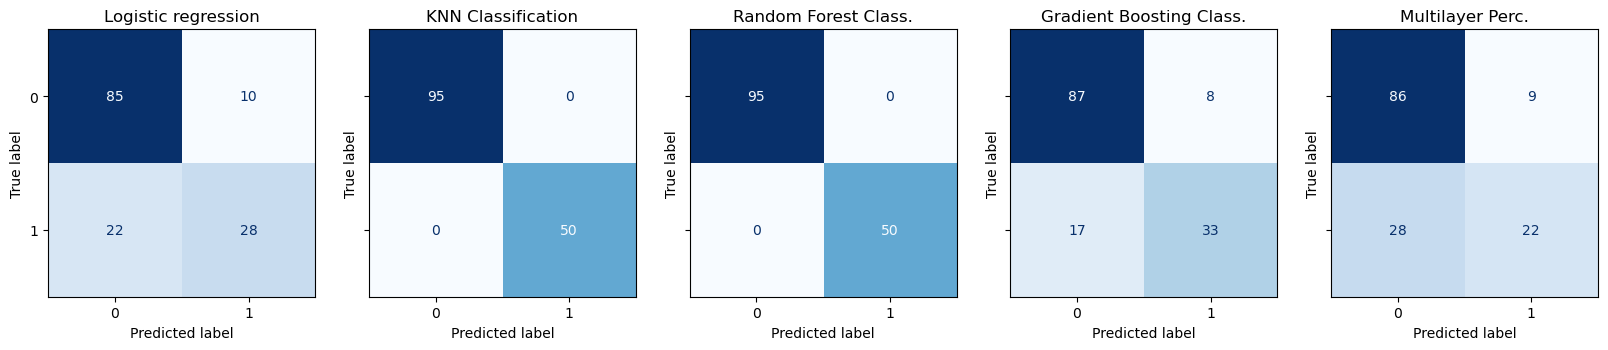

In [32]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5), sharey='row')

ax[0].set_title("Logistic regression")
ax[1].set_title("KNN Classification")
ax[2].set_title("Random Forest Class.")
ax[3].set_title("Gradient Boosting Class.")
ax[4].set_title("Multilayer Perc.")
                

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_best_lr, 
    display_labels=[0,1], colorbar=False, ax=ax[0], cmap='Blues')

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_best_knn, 
    display_labels=[0,1], colorbar=False, ax=ax[1], cmap='Blues')

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_best_rf, 
    display_labels=[0,1], colorbar=False, ax=ax[2], cmap='Blues')

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_best_gb, 
    display_labels=[0,1], colorbar=False, ax=ax[3], cmap='Blues')

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_best_mlp, 
    display_labels=[0,1], colorbar=False, ax=ax[4], cmap='Blues')

## Performance scores

In [33]:
# creating dataframe with all models and performance measures

scores_df = pd.DataFrame({
    'Accuracy': [accuracy_lr, accuracy_knn, accuracy_rf, accuracy_gb, accuracy_mlp],
    'Precision': [precision_lr, precision_knn, precision_rf, precision_gb, precision_mlp],
    'Recall': [recall_lr, recall_knn, recall_rf, recall_gb, recall_mlp],
    'F1': [f1_lr, f1_knn, f1_rf, f1_gb, f1_mlp]},
                        index=['Logistic', 'KNN', 'Random forest', 'Gradient Boosting', 'MLP'])
print("\nPerformance scores:\n")
print(scores_df)


Performance scores:

                   Accuracy  Precision  Recall        F1
Logistic           0.779310   0.736842    0.56  0.636364
KNN                1.000000   1.000000    1.00  1.000000
Random forest      1.000000   1.000000    1.00  1.000000
Gradient Boosting  0.827586   0.804878    0.66  0.725275
MLP                0.744828   0.709677    0.44  0.543210


## ROC curves and ROC AUC

Text(0.5, 1.0, 'ROC curves')

<Figure size 640x480 with 0 Axes>

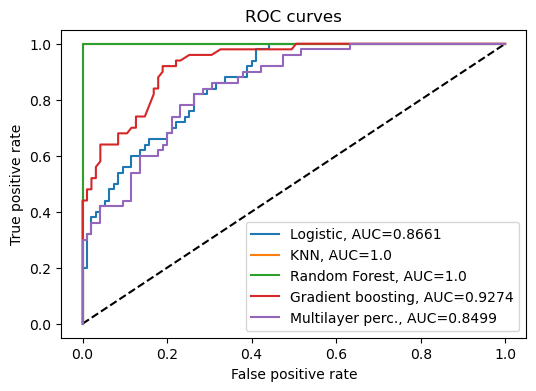

In [34]:
#set up plotting area
plt.figure(0).clf()
plt.figure(figsize=(6,4))
plt.plot([0,1], [0,1], 'k--')
#models
plt.plot(fpr_lr,tpr_lr,label="Logistic, AUC="+str(auc_lr))
plt.plot(fpr_knn,tpr_knn,label="KNN, AUC="+str(auc_knn))
plt.plot(fpr_rf,tpr_rf,label="Random Forest, AUC="+str(auc_rf))
plt.plot(fpr_gb,tpr_gb,label="Gradient boosting, AUC="+str(auc_gb))
plt.plot(fpr_mlp,tpr_mlp,label="Multilayer perc., AUC="+str(auc_mlp))


#add legend
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curves")

# 8. Extra evaluation: focusing on individual observations in the test set

While in the previous section we analyse model performance in the usual way, this section focuses on the incorrectly classified observations by trying to identify what makes it so difficult for some of the models to achieve perfect scores. 

First, we calculate how many times each observation is classified incorrectly. Since two models work perfectly, the maximum number of incorrect classifications is three. 103 observations in the test set were classified correctly by all models, 12 observations were missed by one model, 8 observations by two models and 22 observations by three models.

We could gain further insight by analysing the location of the observations in the hyperplane of the six features. Since we cannot visualize the points on six axes, we need to rely on dimension reduction techniques such as UMAP. In the first UMAP, the true labels are displayed (lightblue= no diabetes). It is obvious that the labels are not clearly separated, which means that we can expect that not all models would be able to tell them apart. While there are obvious regions where lightblue points are clustered (right side of the plot) and dark blue points are more prevalent (frontier on the top left), many dark blue points in the middle are scattered around lightblue points. In fact, these are the observations which get misclassified by three models (see red dots in the second UMAP plot). Observations which get misclassified less than three times are located more towards the top left diagonal frontier. These are the observations which are similar to true diabetes cases so some of the models get those right.

In [35]:
# we put together a dataframe that contains all necessary info

# basis: test data with diabetes status and features
df_X_test= pd.DataFrame(X_test_scaled, columns=["pregnancies", "glucose", "blood_pressure", "BMI", "DPF", "age"])
df_y_test= pd.DataFrame(y_test, columns=["true_label"])

df_big = pd.concat([df_X_test, df_y_test], axis=1)

# adding predicted classes
df_big = pd.concat([df_big, pd.DataFrame(y_pred_best_lr, columns=["pred_LR"])], axis=1)
df_big = pd.concat([df_big, pd.DataFrame(y_pred_best_knn, columns=["pred_KNN"])], axis=1)
df_big = pd.concat([df_big, pd.DataFrame(y_pred_best_rf, columns=["pred_RF"])], axis=1)
df_big = pd.concat([df_big, pd.DataFrame(y_pred_best_gb, columns=["pred_GB"])], axis=1)
df_big = pd.concat([df_big, pd.DataFrame(y_pred_best_mlp, columns=["pred_MLP"])], axis=1)

# adding predicted probabilities
df_big = pd.concat([df_big, pd.DataFrame(y_pred_best_probs_lr, columns=["probs_LR"])], axis=1)
df_big = pd.concat([df_big, pd.DataFrame(y_pred_best_probs_knn, columns=["probs_KNN"])], axis=1)
df_big = pd.concat([df_big, pd.DataFrame(y_pred_best_probs_rf, columns=["probs_RF"])], axis=1)
df_big = pd.concat([df_big, pd.DataFrame(y_pred_best_probs_gb, columns=["probs_GB"])], axis=1)
df_big = pd.concat([df_big, pd.DataFrame(y_pred_best_probs_mlp, columns=["probs_MLP"])], axis=1)

df_big.head(10)

,pregnancies,glucose,blood_pressure,BMI,DPF,age,true_label,pred_LR,pred_KNN,pred_RF,pred_GB,pred_MLP,probs_LR,probs_KNN,probs_RF,probs_GB,probs_MLP
0,0.972166,1.847313,1.789708,0.256055,-0.945054,2.341257,0,1,0,0,1,1,0.898540,0.0,0.248000,0.630683,0.533273
1,-0.560743,-0.539670,-1.117770,0.357979,-0.761533,-0.709317,0,0,0,0,0,0,0.074154,0.0,0.020000,0.159935,0.195184
2,-1.173906,0.234487,0.611001,-0.180763,0.676546,-0.360680,0,0,0,0,0,0,0.402590,0.0,0.132875,0.234906,0.326994
3,-0.867325,-0.442901,-0.960609,0.445343,-0.189912,-0.796476,0,0,0,0,0,0,0.122783,0.0,0.060000,0.185445,0.209447
4,-0.867325,-1.055775,-0.489126,-0.632141,-0.936028,-1.057954,0,0,0,0,0,0,0.019298,0.0,0.010000,0.061832,0.114510
5,0.665584,-0.571927,0.139518,-0.370050,0.733708,0.685231,1,0,1,1,0,0,0.255915,1.0,0.760202,0.361074,0.421190
6,2.198493,0.169974,2.654093,0.954963,-0.866832,1.556824,0,1,0,0,0,0,0.624324,0.0,0.120000,0.266573,0.454645
7,-1.173906,0.524795,-0.960609,0.314297,0.168104,-1.057954,1,0,1,1,0,0,0.344126,1.0,0.652500,0.428579,0.229542
8,1.891912,1.847313,-0.174804,0.387100,-0.836747,0.336594,0,1,0,0,1,1,0.795593,0.0,0.291667,0.594119,0.563901
9,0.665584,0.040947,-0.017643,0.168692,0.766802,0.075117,0,0,0,0,0,0,0.459450,0.0,0.224042,0.361074,0.494802


In [36]:
# coding correctly and incorrectly classified observations by model

# getting the results from LR

def my_logic(row):
    if row["true_label"] == row["pred_LR"]:
        return "correct"
    else:
        return "incorrect"

df_big["result_LR"] = df_big.apply(my_logic, axis=1) 

# getting the results from KNN

def my_logic(row):
    if row["true_label"] == row["pred_KNN"]:
        return "correct"
    else:
        return "incorrect"

df_big["result_KNN"] = df_big.apply(my_logic, axis=1) 

# getting the results from RF

def my_logic(row):
    if row["true_label"] == row["pred_RF"]:
        return "correct"
    else:
        return "incorrect"

df_big["result_RF"] = df_big.apply(my_logic, axis=1) 

# getting the results from GB

def my_logic(row):
    if row["true_label"] == row["pred_GB"]:
        return "correct"
    else:
        return "incorrect"

df_big["result_GB"] = df_big.apply(my_logic, axis=1) 

# getting the results from mlp

def my_logic(row):
    if row["true_label"] == row["pred_MLP"]:
        return "correct"
    else:
        return "incorrect"

df_big["result_MLP"] = df_big.apply(my_logic, axis=1) 

In [37]:
df_big.head(10)

,pregnancies,glucose,blood_pressure,BMI,DPF,age,true_label,pred_LR,pred_KNN,pred_RF,...,probs_LR,probs_KNN,probs_RF,probs_GB,probs_MLP,result_LR,result_KNN,result_RF,result_GB,result_MLP
0,0.972166,1.847313,1.789708,0.256055,-0.945054,2.341257,0,1,0,0,...,0.898540,0.0,0.248000,0.630683,0.533273,incorrect,correct,correct,incorrect,incorrect
1,-0.560743,-0.539670,-1.117770,0.357979,-0.761533,-0.709317,0,0,0,0,...,0.074154,0.0,0.020000,0.159935,0.195184,correct,correct,correct,correct,correct
2,-1.173906,0.234487,0.611001,-0.180763,0.676546,-0.360680,0,0,0,0,...,0.402590,0.0,0.132875,0.234906,0.326994,correct,correct,correct,correct,correct
3,-0.867325,-0.442901,-0.960609,0.445343,-0.189912,-0.796476,0,0,0,0,...,0.122783,0.0,0.060000,0.185445,0.209447,correct,correct,correct,correct,correct
4,-0.867325,-1.055775,-0.489126,-0.632141,-0.936028,-1.057954,0,0,0,0,...,0.019298,0.0,0.010000,0.061832,0.114510,correct,correct,correct,correct,correct
5,0.665584,-0.571927,0.139518,-0.370050,0.733708,0.685231,1,0,1,1,...,0.255915,1.0,0.760202,0.361074,0.421190,incorrect,correct,correct,incorrect,incorrect
6,2.198493,0.169974,2.654093,0.954963,-0.866832,1.556824,0,1,0,0,...,0.624324,0.0,0.120000,0.266573,0.454645,incorrect,correct,correct,correct,correct
7,-1.173906,0.524795,-0.960609,0.314297,0.168104,-1.057954,1,0,1,1,...,0.344126,1.0,0.652500,0.428579,0.229542,incorrect,correct,correct,incorrect,incorrect
8,1.891912,1.847313,-0.174804,0.387100,-0.836747,0.336594,0,1,0,0,...,0.795593,0.0,0.291667,0.594119,0.563901,incorrect,correct,correct,incorrect,incorrect
9,0.665584,0.040947,-0.017643,0.168692,0.766802,0.075117,0,0,0,0,...,0.459450,0.0,0.224042,0.361074,0.494802,correct,correct,correct,correct,correct


In [38]:
# count how many times an observation was incorrectly classified
def count_incorrect(row):
    a = (row['result_LR'] == "incorrect") + (row['result_MLP'] == "incorrect") + (row['result_GB'] == "incorrect")
    
    return a

df_big['n_incorrect'] = df_big.apply(count_incorrect, axis=1) 


In [39]:
# summary
df_big['n_incorrect'].value_counts()

n_incorrect
0    103
3     22
1     12
2      8
Name: count, dtype: int64

In [40]:
# transforming some columns into categorical data type
df_big['n_incorrect'] = df_big['n_incorrect'].astype('category')
df_big['true_label'] = df_big['true_label'].astype('category')

In [42]:
# performing dimensionality reduction by umap
df=df_big
features=["pregnancies", "glucose", "blood_pressure", "BMI", "DPF", "age"]
reducer = umap.UMAP()
embedding = reducer.fit_transform(df[features])

Text(0.5, 1.0, 'UMAP projection with true labels')

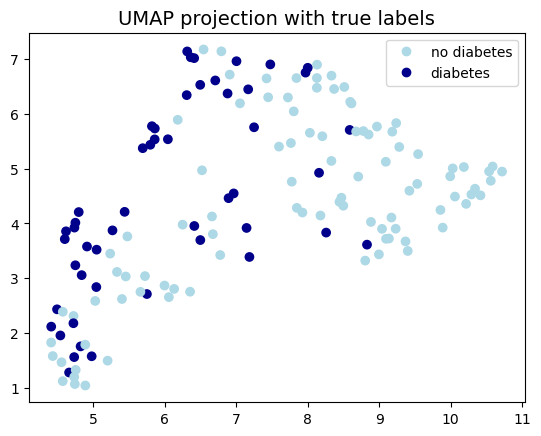

In [43]:
# visualizing true labels
classes = ['no diabetes', 'diabetes']
values = df_big['true_label'].values
colors = ListedColormap(['lightblue','darkblue'])

scatter=plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
c=values, cmap=colors
)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title('UMAP projection with true labels', fontsize=14)


Text(0.5, 1.0, 'UMAP projection with the number of incorrect classification')

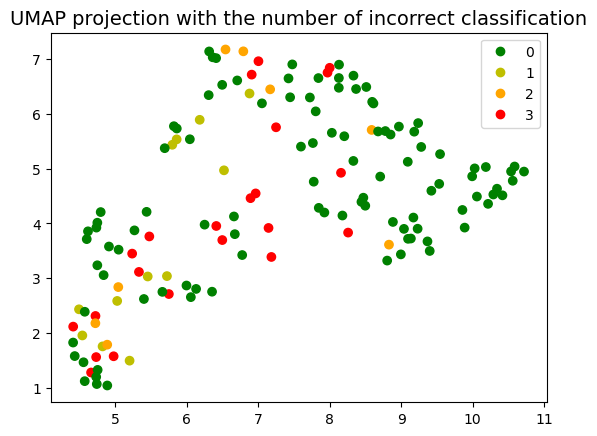

In [44]:
# visualizing the number of incorrect classification
classes = ['0', '1', '2', '3']
values = df_big['n_incorrect'].values
colors = ListedColormap(['g','y', 'orange', 'r'])

scatter=plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
c=values, cmap=colors
)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title('UMAP projection with the number of incorrect classification', fontsize=14)